# RNN Code Along

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## TimeSeries Class

In [2]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (self.xmax - self.xmin)/num_points    # average spacing between xmin~xmax
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)    # a random vector of batch_size rows, and 1 column
        # shape: (batch_size, 1)
        
        # map rand_start onto the xmin~xmax range
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
#         print('ts_start.shape:', ts_start.shape)
        # shape: (batch_size, 1)
        
        # 
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        # ts_start shape: (batch_size, 1)
        # np.arange() shape: (1, steps+1)
        # batch_ts shape: (batch_size, steps+1)
#         print('batch_ts.shape:', batch_ts.shape)
        
        # 
        y_batch = np.sin(batch_ts)
        # y_batch shape: (batch_size, steps+1)
#         print('y_batch.shape:', y_batch.shape)
        
        # Formatting for RNN
        y1 = y_batch[:, :-1].reshape(-1, steps, 1)
        y2 = y_batch[:, 1:].reshape(-1, steps, 1)
        if return_batch_ts:
            return y1, y2, batch_ts
        else:
            return y1, y2

In [3]:
ts_data = TimeSeriesData(num_points=250, xmin=0, xmax=10)

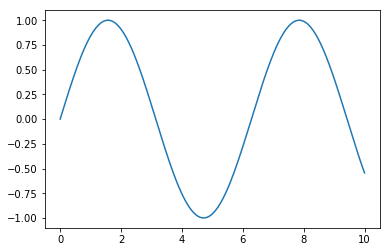

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1, y2, ts = ts_data.next_batch(batch_size=1, steps=num_time_steps, return_batch_ts=True)

In [7]:
print(y1.shape)
print(y2.shape)
print(ts.shape)

(1, 30, 1)
(1, 30, 1)
(1, 31)


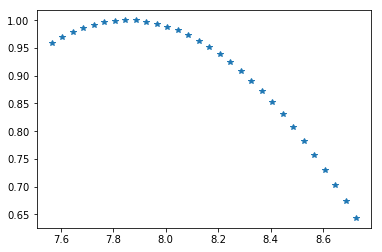

In [8]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

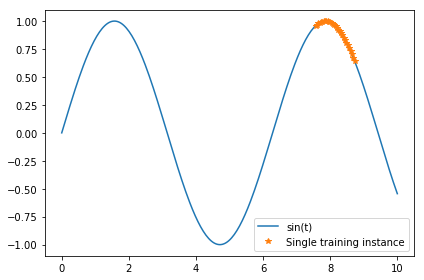

In [9]:
plt.plot(ts_data.x_data, ts_data.y_true, label='sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Single training instance')
plt.legend()
plt.tight_layout()

In [10]:
train_inst = np.linspace(5, 5+ts_data.resolution*(num_time_steps+1), num_time_steps+1)

## RNN Model

In [11]:
tf.reset_default_graph()

#### Constants

In [12]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_iterations = 2000
batch_size = 1

#### Placeholders

The input `X` is a 3-D tensor.  

|Dimension|Denotes|Value in this example |
|---|---|---|
|1st | observations | 1 |
|2nd | timesteps | 30 |
|3rd | number of input features | 1 |

The output `y` is also a 3-D tensor.  

|Dimension|Denotes|Value in this example |
|---|---|---|
|1st | observations | 1 |
|2nd | timesteps | 30 |
|3rd | number of output features | 1 |

In [13]:
X = tf.placeholder(dtype=tf.float32, shape=[None, num_time_steps, num_inputs])
y = tf.placeholder(dtype=tf.float32, shape=[None, num_time_steps, num_outputs])

#### RNN Cell (very basic cell)

***What does an RNN cell look like???***

In [14]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    cell=tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,  # num_neurons=100 in this exampled
                                     activation=tf.nn.relu), 
    output_size=num_outputs)    # num_outputs = 1 in this example

In [42]:
cell.output_size

1

In [43]:
cell.state_size

100

In [50]:
cell.weights

[<tf.Variable 'rnn/output_projection_wrapper/basic_rnn_cell/kernel:0' shape=(101, 100) dtype=float32_ref>,
 <tf.Variable 'rnn/output_projection_wrapper/basic_rnn_cell/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'rnn/output_projection_wrapper/kernel:0' shape=(100, 1) dtype=float32_ref>,
 <tf.Variable 'rnn/output_projection_wrapper/bias:0' shape=(1,) dtype=float32_ref>]

In [37]:
outputs, states = tf.nn.dynamic_rnn(cell=cell, 
                                    inputs=X, 
                                    dtype=tf.float32)

In [38]:
print(outputs)
print(states)

Tensor("rnn_1/transpose:0", shape=(?, 30, 1), dtype=float32)
Tensor("rnn_1/while/Exit_2:0", shape=(?, 100), dtype=float32)


`outputs` is a tensor of shape `(?, 30, 1)`, same as the shape of placeholder `X`.  
`states` is a tensor of shape `(?, 100)`, but why???

#### Loss Function (MSE)

Loss is defined by mean square error.  
Error is calculated by `outputs-y`, which is a tensor of shape `(?, 30, 1)`.  
Then perform element-wise square operation with `tf.square()` function, again gets a tensor.  
Then reduce that tensor to a number with `tf.reduce_mean()` function.  
Note that no calculations are actually performed. Actual calculation is executed only when you `run()` a `tf.Session()`.

In [65]:
outputs-y

<tf.Tensor 'sub_5:0' shape=(?, 30, 1) dtype=float32>

In [63]:
tf.square(outputs-y)

<tf.Tensor 'Square_1:0' shape=(?, 30, 1) dtype=float32>

In [16]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [64]:
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

#### Optimizer

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [66]:
optimizer

In [18]:
train = optimizer.minimize(loss)

In [67]:
train

<tf.Operation 'Adam' type=NoOp>

In [19]:
init = tf.global_variables_initializer()

In [68]:
init

<tf.Operation 'init' type=NoOp>

#### Run a Session

In [20]:
saver = tf.train.Saver()

In [69]:
saver

In [79]:
X_batch, y_batch = ts_data.next_batch(batch_size=batch_size, steps=num_time_steps)

In [80]:
X_batch.shape

(1, 30, 1)

In [81]:
y_batch.shape

(1, 30, 1)

In each iteration we generate a random segment from `y=sin(x)` 0<x<10, which is 'true' data, and feed it into the RNN network.

During `sess.run()`, the session tries to evaluate `train` (an `tf.Operation` object), and trace back to the definition of `train` and found that it operates `tf.AdamOptimizer()` on `loss`.  
The session then follows definition of `loss` and see that it comes form `outputs` and `y`.  
`y` is fed in via the `feed_dict` parameter, so `sess` knows where to find it.  
`outputs` is further tracked down and it's found to be the output of an RNN that depends on `X` and `cell`.  
Again `X` was fed in via the `feed_dict`, and `cell` is found to be an `RNNCell` object which saves information about what happed before and what to do with `X`.

In [21]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):  # num_train_iterations = 2000 in this example
        X_batch, y_batch = ts_data.next_batch(batch_size=batch_size, steps=num_time_steps)
        
        sess.run(train, feed_dict={X: X_batch, y:y_batch})
        
        if iteration %100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y:y_batch})
            print(iteration, '\tMSE', mse)
    
    saver.save(sess, "./rnn_time_series_model_codealong")

0 	MSE 0.334043
100 	MSE 0.0431431
200 	MSE 0.076947
300 	MSE 0.010399
400 	MSE 0.0334076
500 	MSE 0.0439959
600 	MSE 0.00194697
700 	MSE 0.0333429
800 	MSE 0.01168
900 	MSE 0.00367498
1000 	MSE 0.0247448
1100 	MSE 0.00557653
1200 	MSE 0.0199047
1300 	MSE 0.00286544
1400 	MSE 0.000120164
1500 	MSE 0.00459243
1600 	MSE 0.000950146
1700 	MSE 0.0120456
1800 	MSE 0.00716437
1900 	MSE 0.000258766


#### Use the trained mode to predict one step in the future

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model_codealong")
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


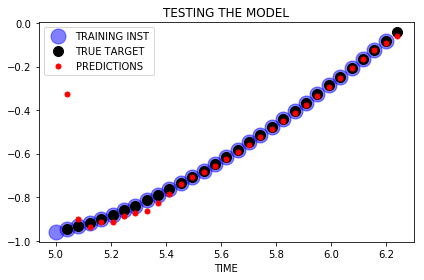

In [23]:
plt.title("TESTING THE MODEL")

# Training instance
plt.plot(train_inst[:-1], np.sin(train_inst)[:-1], 
         'bo', markersize=15, alpha=0.5, label='TRAINING INST')

# True target
plt.plot(train_inst[1:], np.sin(train_inst)[1:], 
         'ko', markersize=10, label='TRUE TARGET')

# Model predictions
plt.plot(train_inst[1:], y_pred[0, :, 0], 
         'r.', markersize=10, label='PREDICTIONS')

plt.xlabel("TIME")
plt.legend()
plt.tight_layout()

## Generating New Sequence

In [86]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_time_series_model_codealong')
    
    # SEED ZEROS
    zero_seq_seed = [0.0 for _ in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])  # only takeout the last element in y_pred

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


In [95]:
y_pred[0, -1, 0]

0.20569074

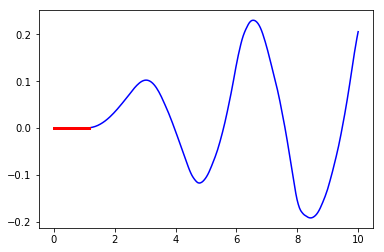

In [101]:
plt.plot(ts_data.x_data, zero_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], 'r', linewidth=3)

In [96]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_time_series_model_codealong')
    
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])  # only takeout the last element in y_pred

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


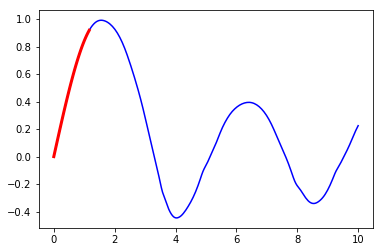

In [99]:
plt.plot(ts_data.x_data, training_instance, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], 'r', linewidth=3)